# Homework 5: Clustering and Feature Selection (50 points)

**Pandas Cheat Sheet**: There are several Pandas documentation files you can find with a simple search. This is one that is short and informative: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 5 is due Friday, March 8 at noon. Late work will not be accepted.  

In [40]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


## 1. Clustering: Crime Rates (22 points) ##

The data below contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban area:

-    Murder: 	 	Murder arrests (per 100,000)
- 	Assault: 	 	Assault arrests (per 100,000)
- 	UrbanPop: 	 	Percent urban population
- 	Rape: 	 	Rape arrests (per 100,000) mpg: miles per gallon



In [2]:
# this commands loads the data into a data frame
crime_df=pd.read_csv("crime_rates.csv")
crime_df.head(10)


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


#### Question 1.1 ( Complete linkage, 5 points)

Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states. Cut the dendogram at a height that results in three distinct clusters. Which states belong to which clusters?

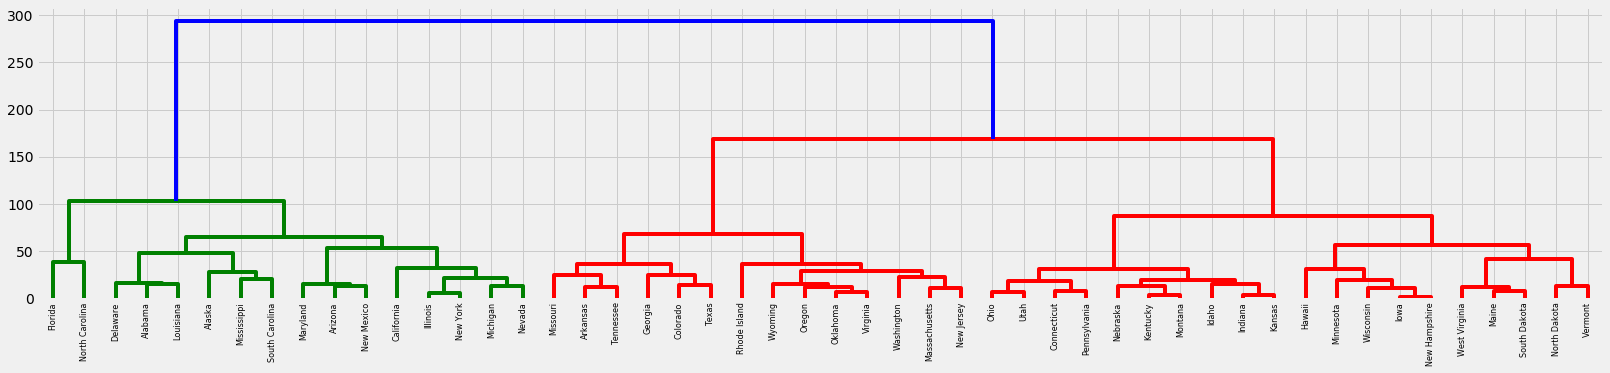

In [7]:
# code here and in additional cells if needed

crime = crime_df[['Murder','Assault','UrbanPop','Rape']]

cluster_1 = linkage(crime, 'complete')

labels = np.array(crime_df.State)

plots.figure(figsize=(25, 5)) 
dendrogram(cluster_1, orientation='top', labels=labels, distance_sort='descending')
plots.show()


Cluster 1 (Green): Florida, North Carolina, Delaware, Alabama, Louisiana, Alasa, Mississippi, South Carolina, Maryland, Arizona, New Meixco, California, Illinois, New York, Michiigan, Nevada
                    
Cluster 2(Left Red): From Missouri to New Jersey on the plot

Cluster 3(Right Red): From Ohio to Vermont on the plot

#### Question 1.2 (Standard units, 5 points)

Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states **after standardizing the four variables.** What effect does standardization have on the clustering obtained? Should the variables be standardized before the clustering? Justify your answer.


In [9]:
# code here and in additional cells if needed
#Taken from class demos
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)

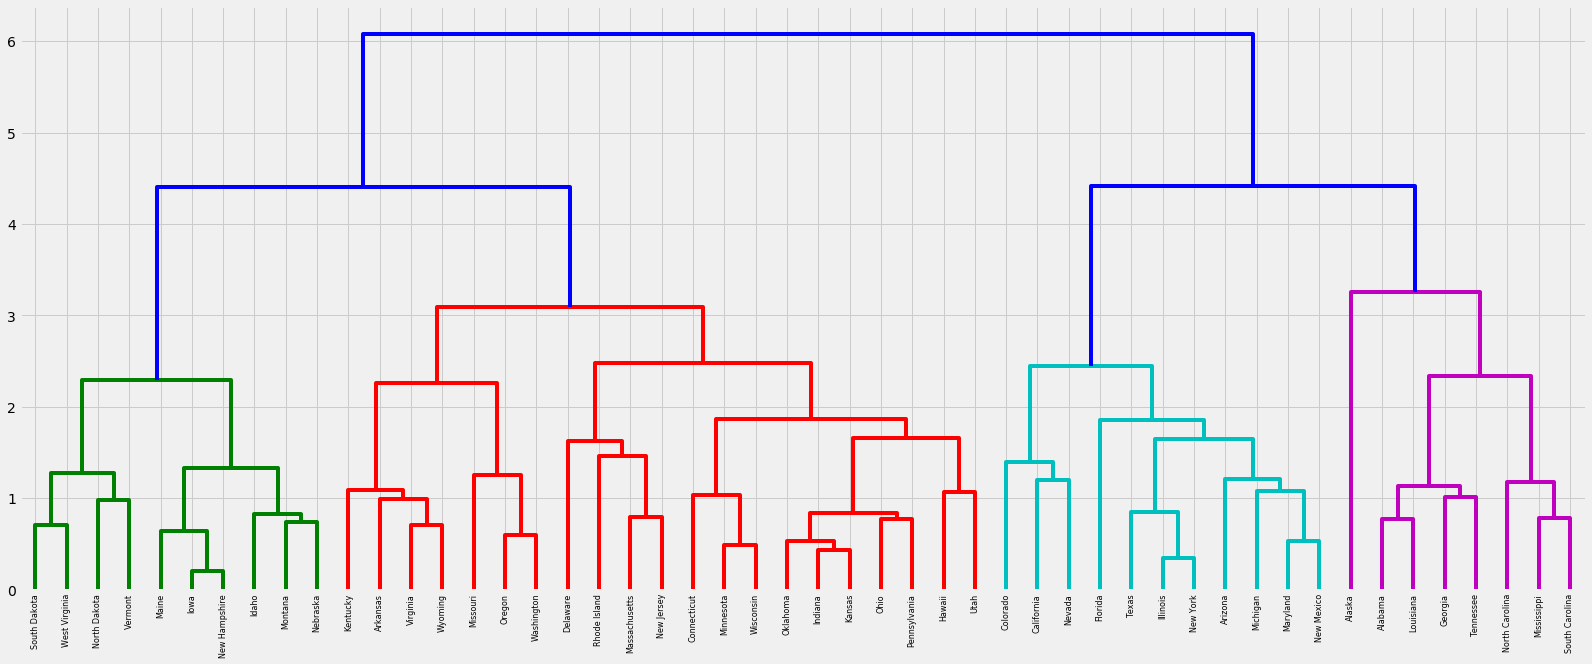

In [10]:
crime_stdunits = pd.DataFrame({"Murder": standard_units(crime_df['Murder']),
        "Assault": standard_units(crime_df['Assault']),
        "UrbanPop": standard_units(crime_df['UrbanPop']),
        "Rape": standard_units(crime_df['Rape'])})

clust2 = linkage(crime_stdunits, 'complete')

labels = np.array(crime_df['State'])

plots.figure(figsize=(25, 10))  
dendrogram(clust2,  
            orientation='top',
            labels=labels,
            distance_sort='descending')
plots.show()

Using the same variables and same clustering method, if you standardize the units first, there are two more clusters. Standardization evens out the variables, meaning that the weightings are more equal. The splits end up more reflective of what the effects the variables have on the clustering method. The data should be standardized before clustering because the numbers of each crime have different ranges across states. Without clustering, the variables with the largest ranges will have the largest effects on clustering when it should be fairly equal. 

#### Question 1.3 (K-means, 6 points)

Perform K-means on the standardized data. The goal here is to determine a reasonable K using the **elbow plot** argument we discussed in class. For K=1,2,...,10 calculate the objective function (sum of squared deviations) at the step where the K-means algorithm converges and plot it against K. Discuss which K you would choose to perform K-means.


In [13]:
# code here and in additional cells if needed
## Code taken from class demos

def initialize_centroids(df,K):
    random_ids = np.random.permutation(df.shape[0])
    centroids = df.iloc[random_ids[:K]]
    return centroids

def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((np.array(pt1)[1:4] - np.array(pt2)[1:4])**2))

def compute_distance(df, centroids):
    K=centroids.shape[0]
    distances_ar = np.zeros((df.shape[0], K))
    
    # we used a similar approach  in developing kNN

    for k in range(K):
        point=centroids.iloc[k]        
        def distance_from_point(row):
            return distance(point, row)
        distances_ar[:,k] = df.apply(distance_from_point,axis=1).values
    return distances_ar

def compute_sse(df, labels, centroids,K):
    distances_ar = np.zeros(df.shape[0])
    for k in range(K):
        point=centroids.iloc[k]        
        def distance_from_point(row):
            return distance(point, np.array(row))
        distances_ar[labels == k] = df[labels == k].apply(distance_from_point,axis=1).values
    return np.sum(distances_ar)

def compute_centroids(df, labels, K):
        centroids = np.zeros((K, df.shape[1]))
        for k in range(K):
            centroids[k, :] = df[labels == k].mean()
        return centroids

# for selecting K
def Kmeans_sse(df,K):
    #define the maximum number of iterations
    max_iter=20
    
    #initialize centroids
    centroids=initialize_centroids(df,K)
    
    for i in range(max_iter):
            old_centroids = centroids
            dist_matrix = compute_distance(df, old_centroids)
            clust=np.argmin(dist_matrix, axis=1)
            centroids = pd.DataFrame(compute_centroids(df,clust,K))
    
    # return SSE
    return compute_sse(df,clust,centroids,K)

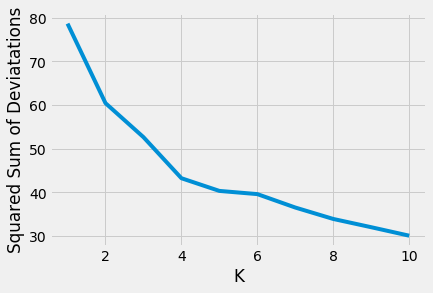

In [15]:
cent0 = initialize_centroids(crime_stdunits,3)

clust0=np.argmin(compute_distance(crime_stdunits,cent0), axis=1)

K = np.arange(1,11)
SSE = np.zeros(10)

for k in K:
    SSE[k-1] = Kmeans_sse(crime_stdunits, k)
    
plots.plot(K, SSE)
plots.xlabel('K')
plots.ylabel('Squared Sum of Deviatations');

I would choose a K of 4, as that is when the elbow plots decrease starts to flatten out (the SSE get smaller at a smaller rate). 

#### Question 1.4 (K-means clusters, 6 points)

Perform K-means on the standardized data with the K you proposed in Q1.3. How do the clusters compare to what you discovered using hierarchical clustering?


In [16]:
# code here and in additional cells if needed
cent = initialize_centroids(crime_stdunits,4)

clust_Kmeans = np.argmin(compute_distance(crime_stdunits, cent), axis=1)
crime_df['class'] = clust_Kmeans
print(crime_df['State'][crime_df['class'] == 0])
print(crime_df['State'][crime_df['class'] == 1])
print(crime_df['State'][crime_df['class'] == 2])
print(crime_df['State'][crime_df['class'] == 3])

12        Illinois
29      New Jersey
31        New York
38    Rhode Island
Name: State, dtype: object
8        Florida
9        Georgia
17     Louisiana
19      Maryland
30    New Mexico
41     Tennessee
42         Texas
Name: State, dtype: object
1            Alaska
2           Arizona
4        California
5          Colorado
10           Hawaii
20    Massachusetts
21         Michigan
24         Missouri
27           Nevada
34             Ohio
36           Oregon
43             Utah
46       Washington
Name: State, dtype: object
0            Alabama
3           Arkansas
6        Connecticut
7           Delaware
11             Idaho
13           Indiana
14              Iowa
15            Kansas
16          Kentucky
18             Maine
22         Minnesota
23       Mississippi
25           Montana
26          Nebraska
28     New Hampshire
32    North Carolina
33      North Dakota
35          Oklahoma
37      Pennsylvania
39    South Carolina
40      South Dakota
44           Vermont
45

These clusters are less evenly divided as the first two only have 4 and 6 states in it respectively while the other two have many. Also, the states are not in similar buckets between the two. For example, in heirarchial clustering, IL and NJ are in two different clusters while with KMeans, they make up half of the first cluster. 

## 2. Model selection: Colleges (28 points) ##

The data below contains statistics for a large number of US Colleges from the 1995 issue of US News and World Report.

The data frame below has 777 observations on the following 18 variables:

-  ‘Private’ A factor with levels ‘No’ and ‘Yes’ indicating private or public university

-     ‘Apps’ Number of applications received

-     ‘Accept’ Number of applications accepted

-     ‘Enroll’ Number of new students enrolled

-    ‘Top10perc’ Pct. new students from top 10% of H.S. class

-     ‘Top25perc’ Pct. new students from top 25% of H.S. class

-     ‘F.Undergrad’ Number of fulltime undergraduates

-     ‘P.Undergrad’ Number of parttime undergraduates

-     ‘Outstate’ Out-of-state tuition

-     ‘Room.Board’ Room and board costs

-     ‘Books’ Estimated book costs

-     ‘Personal’ Estimated personal spending

-     ‘PhD’ Pct. of faculty with Ph.D.'s

-     ‘Terminal’ Pct. of faculty with terminal degree

-     ‘S.F.Ratio’ Student/faculty ratio

-     ‘perc.alumni’ Pct. alumni who donate

-     ‘Expend’ Instructional expenditure per student

-     ‘Grad.Rate’ Graduation rate

### The goal is to predict the number of applications received using the other variables in the dataset. ###

In [17]:
# this commands loads the data into a data frame
college_df=pd.read_csv("College.csv")
college_df.head(5)

,College,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


#### Question 2.1 ( Data preparation, 5 points)

Change the "Private' variable to a binary 0-1 variable. Standardize the rest of the variables using the StandardScaler function in sklearn. Split the data into a training set and a test set where the training set should have 80% random colleges.


In [18]:
# code here and in additional cells if needed
college_df['Private'] = (college_df['Private'] == 'Yes')*1

In [ ]:
scaler = StandardScaler()

college_df['Accept'] = scaler.fit_transform(np.array(college_df['Accept']).reshape(-1, 1))
college_df['Enroll'] = scaler.fit_transform(np.array(college_df['Enroll']).reshape(-1, 1))
college_df['Top10perc'] = scaler.fit_transform(np.array(college_df['Top10perc']).reshape(-1, 1))
college_df['Top25perc'] = scaler.fit_transform(np.array(college_df['Top25perc']).reshape(-1, 1))
college_df['F.Undergrad'] = scaler.fit_transform(np.array(college_df['F.Undergrad']).reshape(-1, 1))
college_df['P.Undergrad'] = scaler.fit_transform(np.array(college_df['P.Undergrad']).reshape(-1, 1))
college_df['Outstate'] = scaler.fit_transform(np.array(college_df['Outstate']).reshape(-1, 1))
college_df['Room.Board'] = scaler.fit_transform(np.array(college_df['Room.Board']).reshape(-1, 1))
college_df['Books'] = scaler.fit_transform(np.array(college_df['Books']).reshape(-1, 1))
college_df['Personal'] = scaler.fit_transform(np.array(college_df['Personal']).reshape(-1, 1))
college_df['PhD'] = scaler.fit_transform(np.array(college_df['PhD']).reshape(-1, 1))
college_df['Terminal'] = scaler.fit_transform(np.array(college_df['Terminal']).reshape(-1, 1))
college_df['S.F.Ratio'] = scaler.fit_transform(np.array(college_df['S.F.Ratio']).reshape(-1, 1))
college_df['perc.alumni'] = scaler.fit_transform(np.array(college_df['perc.alumni']).reshape(-1, 1))
college_df['Expend'] = scaler.fit_transform(np.array(college_df['Expend']).reshape(-1, 1))
college_df['Grad.Rate'] = scaler.fit_transform(np.array(college_df['Grad.Rate']).reshape(-1, 1))


In [20]:
len(college_df)*.8
##Sample size of training data set is 622

621.6

In [21]:
train_df = college_df.sample(622)
test_df = college_df[~college_df.index.isin(train_df.index)]

#### Question 2.2 ( Multiple Linear Regression, 5 points)

Fit a multiple linear regression model on the training data set and use it to predict number of applications in the test set. Report the training error which is defined as the mean absolute deviation (average of |prediction-truth|).

In [24]:
# code here and in additional cells if needed
x_train = train_df.loc[:,train_df.columns != 'Apps']
y_train = train_df.iloc[:,2]
x_test = test_df.loc[:,test_df.columns != 'Apps']
y_test = test_df.iloc[:,2]

In [27]:
reg = LinearRegression()
reg.fit(x_train.iloc[:,1:], y_train)
reg.intercept_, reg.coef_

pred_y = reg.predict(x_test.iloc[:,1:])

np.average(abs(pred_y - y_test))

625.8395940106384

The training error is 625.84. 

#### Question 2.3 ( Lasso, 7 points)

Fit lasso models on the training data set using five $\alpha$ values of your choice. Report the training error for each of the $\alpha$. For the model with the lowest training error, report the variables that have non-zero coefficients.

In [31]:
# code here and in additional cells if needed
alpha = [.01, .1, 1, 10, 100]
test_error = []

for a in alpha:  
    lasso = Lasso(alpha=a)
    lasso.fit(x_train.iloc[:,1:],y_train)
    pred_y = lasso.predict(x_test.iloc[:,1:])
    error = np.average(abs(pred_y - y_test))
    test_error.append(error)

print(alpha, test_error) #Respectively


[0.01, 0.1, 1, 10, 100] [625.8306767766925, 625.7504216877262, 624.9478705345206, 617.3844240139973, 603.677878852705]
alpha: 0.01 error: 625.8306767766925
alpha: 0.1 error: 625.7504216877262
alpha: 1 error: 624.9478705345206
alpha: 10 error: 617.3844240139973
alpha: 100 error: 603.677878852705


In [38]:
#Lowest error is for alpha = 100
lasso = Lasso(alpha=100)
lasso.fit(x_train.iloc[:,1:], y_train)
print (lasso.coef_)


[-0.00000000e+00  1.63554542e+00 -1.01153945e+00  4.06153178e+01
 -9.06961385e+00  8.04196416e-02  6.35765228e-02 -1.01913617e-01
  1.48208319e-01  2.66066986e-01 -1.20098576e-02 -5.43393694e+00
 -1.12022745e+00  1.48121406e+01  5.38641322e-02  6.30038087e-02
  5.62091208e+00]


Variables w/ Non Zero Coefficients: 2, 3, 4, 5, 12, 13, 14, 16

Enrolll, Top10Perc, Top25Perc, Terminal, SF Ratio, Perc.Alumi and Grad.Rate had nonzero coeffecients. 






#### Question 2.4 ( Ridge Regression, 7 points)

Fit ridge regression models on the training data set using five $\alpha$ values of your choice. Report the training error for each of the $\alpha$. 

In [41]:
# code here and in additional cells if needed
alpha = [.01, .1, 1, 10, 100]
test_error = []

for a in alpha:  
    ridge = Ridge(alpha=a)
    ridge.fit(x_train.iloc[:,1:],y_train)
    pred_y = ridge.predict(x_test.iloc[:,1:])
    error = np.average(abs(pred_y - y_test))
    test_error.append(error)

print(alpha, test_error) #Respectively

[0.01, 0.1, 1, 10, 100] [625.8339013718066, 625.782779299858, 625.2823772504554, 621.1657317499286, 612.1838160501394]


Alphas: 0.01, 0.1, 1, 10, 100
Test Errors: 625.83, 625.78, 625.28, 621.17, 612.18

Line up respectively, for first alpha of 0.01, first test error in list of 625.83 and onwards.

#### Question 2.5 ( Discussion, 4 points)

Comment on the results obtained. How accurately can we predict the number of college applications received?

The error for MLR was 625. After using Lasso and Ridge to get lower values, it turns out that the lowest error is with Lasso with an alpha of 100, and the next best is Ridge with an alpha of 100. The error is different in each context. At a school with hundrededs of thousands of applications, the error is small enough if that it will fairly accurately predict number of apps. However, when a school is only getting a few hundred, the error is too large and the prediction is not going to be close to the number. It is a relative number.

We could test other alpha values for all the methods to try to get the lowest one if we wanted to more accurately predict the number, but I doubt it would get you much closer. 